# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [4]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

data_dir = "./dataset/"

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "../dataset/"
image_dir = "../images/"


## Loading the data

In [5]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

## Feature Engineering, Transformation and Data Imputation

- In cases where the PWD_update and PH_NUM_update are after the transaction date we risk using the future information to make a predictive modeling. This on one hand might improve the model performance for the training/test data but it has a risk of 

In [7]:
def convert_future_info_to_past(df, tran_date, pwd_phn_date, cust_since_date ):
    # for cases where transaction date is after pwd_update/phone_num_update date
    # then we'd get a -ve value
    # so replace the -ve values by tran_date - cust_since_date
    return np.where((df[tran_date]-df[pwd_phn_date]).dt.days <0,
                    (df[tran_date]- df[cust_since_date]).dt.days, 
                    (df[tran_date]-df[pwd_phn_date]).dt.days)

In [8]:
def convert_date_format(x):
    if len(str(x).split("/"))>1:
        m,d,y=str(x).strip().split()[0].split("/")
        if d=='0':
            d='1'
        elif d=='31':
            d='30'
        return "-".join([y,m,d])
    else:
        return str(x).split()[0]

def feature_engineering(df):
    # conver the _DT columns to pandas datetime
    cols_DT = [c for c in df.columns if "_DT" in c]
    df[cols_DT] = df[cols_DT].apply(pd.to_datetime)
    # convert the TRAN_Timestamp to only hour
    df["TRAN_HOUR"]=pd.to_datetime(df['TRAN_TS']).dt.strftime("%H")
    # Fill the Nulls for Phone update by the cust_since_date and keep only date
    df["PH_NUM_UPDT_DT"]=pd.to_datetime(df["PH_NUM_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Fill the Nulls for pwd update by the cust_since_date and keep only date
    df["PWD_UPDT_DT"]=pd.to_datetime(df["PWD_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Num of days between TRAN_DATE and PWD_UPDATE_DAYS
    df["PWD_UPDT_DAYS"] = convert_future_info_to_past(df, "TRAN_DT",
                                                      "PWD_UPDT_DT",
                                                      "CUST_SINCE_DT")
    
    
    #np.where( (df["TRAN_DT"]-df["PWD_UPDT_DT"]).dt.days <0,
    #                               (df["TRAN_DT"]- df["CUST_SINCE_DT"]).dt.days, 
    #                               (df["TRAN_DT"]-df["PWD_UPDT_DT"]).dt.days
    #                              )
    
    # Num of days between TRAN_DATE and PHONE_NUM_UPDATE_DAYS
    df["PH_NUM_UPDT_DAYS"] = convert_future_info_to_past(df, "TRAN_DT",
                                                         "PH_NUM_UPDT_DT",
                                                         "CUST_SINCE_DT")
    
    #np.where( (df["TRAN_DT"]-df["PH_NUM_UPDT_DT"]).dt.days <0,
    #                                  (df["TRAN_DT"]- df["CUST_SINCE_DT"]).dt.days,
    #                                  (df["TRAN_DT"]-df["PH_NUM_UPDT_DT"]).dt.days
    #                                 )
    
    # Num of days between TRAN_DATE and CUST_SINCE_DATE
    #df["TRAN_DAYS"] = (df["TRAN_DT"] - df["CUST_SINCE_DT"]).dt.days
    # Num of days between PWD update and phone number update
    #df["PH_NUM_PWD_DAYS"]=df["PH_NUM_UPDT_DAYS"] - df["PWD_UPDT_DAYS"]
    df["RAND"] =np.random.rand(df.shape[0])
    return df

In [9]:
def get_imputation_values(df):
    
    # find numerical and categorical columns
    nume_cols = list(df.select_dtypes(include="number").columns)
    cate_cols = list(df.select_dtypes(exclude="number").columns)
    nume_cols.remove('CUST_ZIP')
    cate_cols.append('CUST_ZIP')
    nume_cols.remove('FRAUD_NONFRAUD')
   
    impute_vals={}

    for col in df.columns:
        if col in nume_cols:
            impute_vals[col] = df[col].median()
        elif col in cate_cols:
            impute_vals[col] = df[col].mode()[0]
    return nume_cols, cate_cols, impute_vals

In [10]:
def impute_data(df, impute_dict):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [11]:
def transform_cate_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

## Modelling

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [22]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        self.model.fit(self.X_train, self.y_train)
        
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = image_dir+"nb4_displot_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):
        # find the feature importance for both single model 
        # or a grid search cv model
        try:
            imp = self.model.feature_importances_
        except:
            imp = self.model.best_estimator_.feature_importances_

        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":imp})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = image_dir+"nb4_feat_imp_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')
        
    def plot_roc_curve(self):
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)
        label_name = self.savename +"\nAUC = "+str(roc_auc)
        
        plot_roc_curve(self.model, self.X_test, self.y_test,
                       lw=3., color='C2', label=label_name)
        plt.title("ROC Curve", fontsize=18)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xticks(fontsize=16);
        plt.yticks(fontsize=16);
        plt.legend(loc="center", fontsize=14);
        plt.axvline(x=0, color='k', ls='--', lw=1)
        plt.axhline(y=0, color='k', ls='--', lw=1)
        plt.axhline(y=1, color='k', ls='--', lw=1)
        
        figname = image_dir+"nb4_roc_curve_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

## Modeling 1: Numerical features (Given only)

In [21]:
df1 = df_train0.copy()
df1["FRAUD_NONFRAUD"] =  df1["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1 = feature_engineering(df1)
nume_cols, cate_cols, impute_vals = get_imputation_values(df1)
df1 = impute_data(df1, impute_vals)
df1 = transform_cate_data(df1)

In [15]:
df1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD,TRAN_HOUR,PH_NUM_UPDT_DT,PWD_UPDT_DT,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,RAND
2413,487.93,3714.91,43,5,1037,5/18/2020 4:7:20,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-13,1,05,2020-05-01,1988-01-11,12146,347,0.211647
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-29,0,22,1987-04-05,2017-04-12,1478,12443,0.286586


In [16]:
df1_te = df_test0.copy()
df1_te["FRAUD_NONFRAUD"] =  df1_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1_te = feature_engineering(df1_te)
df1_te = impute_data(df1_te, impute_dict=impute_vals)
df1_te = transform_cate_data(df1_te)

In [17]:
nume_cols1 = list(df1.select_dtypes(include="number").columns)
nume_cols1.remove('CUST_ZIP')  
nume_cols1.remove("FRAUD_NONFRAUD")
nume_cols1

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age',
 'PWD_UPDT_DAYS',
 'PH_NUM_UPDT_DAYS',
 'RAND']

In [18]:
X_train1, y_train1 = df1[nume_cols1], df1["FRAUD_NONFRAUD"]
X_test1,  y_test1  = df1_te[nume_cols1], df1_te["FRAUD_NONFRAUD"]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((11200, 8), (11200,), (2800, 8), (2800,))

In [19]:
X_train1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,RAND
2413,487.93,3714.91,43,5,1037,12146,347,0.211647
1003,4.84,0.00,53,5,305,1478,12443,0.286586


In [49]:
lgbm = LGBMClassifier()
rf   = RandomForestClassifier(max_depth=12)
xgb  = XGBClassifier(max_depth=12)

mods = [lgbm, rf, xgb]

proba = np.zeros((X_test1.shape[0], 3))

for i,mod in enumerate(mods):
    mod.fit(X_train1, y_train1)
    proba[:,i]=mod.predict_proba(X_test1)[:,1]

[21:20:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
lgbm = LGBMClassifier()
lgbm.fit(X_train1, y_train1)
y_pred = lgbm.predict(X_test1)
proba  = lgbm.predict_proba(X_test1)

In [77]:
f1_score(y_test1, y_pred)

0.8962088253573648

In [79]:
fpr, tpr, thresholds = roc_curve(y_test1, proba[:,1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.209217, G-Mean=0.931


In [83]:
th_best = thresholds[ix]
pred = (pr>0.5).astype(int) 
f1 = f1_score(pred, y_test1)
print (f1)

0.8963376784605833


In [84]:
from sklearn.metrics import precision_recall_curve

In [108]:
precision, recall, thresholds = precision_recall_curve(y_test1, proba[:,1])

In [113]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.366618, F-Score=0.898


In [114]:
th_best = thresholds[ix]
th_best

0.36661840228329057

In [110]:
precision

array([0.47115385, 0.47085456, 0.47112118, ..., 1.        , 1.        ,
       1.        ])

In [111]:
fscore

array([0.64052288, 0.64      , 0.64024625, ..., 0.00479042, 0.00239808,
       0.        ])

In [119]:
pred = (proba[:,1]>th_best).astype(int) 
f1 = f1_score(y_test1, pred)
print (f1)

0.8970944309927361


In [55]:
pr = np.sum(proba, axis=1)/3.

In [81]:
for th in [th_best, 0.4, 0.45, 0.5, 0.55, 0.6]:
    
    pred = (pr>th).astype(int) 
    f1 = f1_score(pred, y_test1)
    print (th, f1)

0.20921656469229497 0.8906976744186047
0.4 0.8941896024464832
0.45 0.8972772277227723
0.5 0.8963376784605833
0.55 0.89167188478397
0.6 0.8900062853551225


In [71]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test1, y_pred)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Accuracy = 93.82% F1 Score= 89.26% 
Precision=92.42% Recall= 86.31%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.92      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.92      0.92      2800
weighted avg       0.94      0.94      0.94      2800



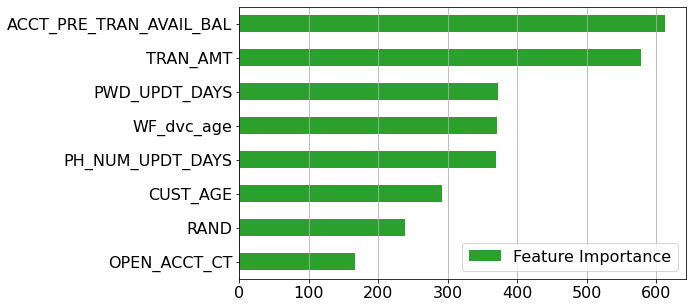

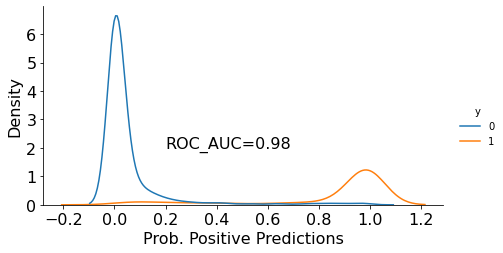

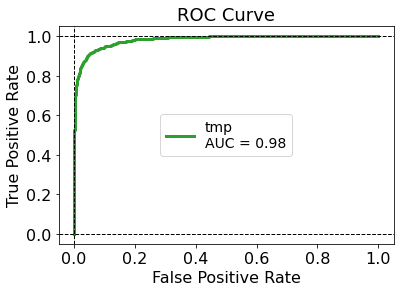

In [23]:
lgbm = LGBMClassifier()
mod = Model_training(lgbm,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")

mod_tr, _= mod.print_metrics()
mod.feature_importance()
mod.displot()
mod.plot_roc_curve()

In [28]:
nume_cols2 = list(df_train0.select_dtypes(include="number").columns)
nume_cols2.remove('CUST_ZIP')   
nume_cols2

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age']

In [29]:
X_train2, y_train2 = df1[nume_cols2], df1["FRAUD_NONFRAUD"]
X_test2,  y_test2  = df1_te[nume_cols2], df1_te["FRAUD_NONFRAUD"]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 5), (11200,), (2800, 5), (2800,))

In [30]:
lgbm = LGBMClassifier()
lgbm.fit(X_train2, y_train2)
y_pred = lgbm.predict(X_test2)
ac = accuracy_score(y_test2, y_pred)
f1 = f1_score(y_test2, y_pred)
print (ac, f1)

0.9314285714285714 0.8799999999999999


In [27]:
lgbm = LGBMClassifier()
lgbm.fit(X_train1, y_train1)
y_pred = lgbm.predict(X_test1)
ac = accuracy_score(y_test1, y_pred)
f1 = f1_score(y_test1, y_pred)
print (ac, f1)

1.0 1.0


In [35]:
lgbm = LGBMClassifier()
lgbm.fit(X_train1, y_train1)
pred = lgbm.predict(X_test1)
proba = lgbm.predict_proba(X_test1)
proba[:,1]

array([0.99997008, 0.99997008, 0.00001326, ..., 0.99997008, 0.00001326,
       0.99997008])

In [36]:
pr = lgbm.predict_proba(X_test1)
pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                      'pred_1':pr[:,1], 
                      'y': y_test1})

In [38]:
pr_df.head(10)

,pred_0,pred_1,y
3032,0.000030,0.999970,1
4838,0.000030,0.999970,1
7117,0.999987,0.000013,0
9795,0.000030,0.999970,1
5640,0.999987,0.000013,0
7216,0.999987,0.000013,0
7944,0.999987,0.000013,0
5358,0.000030,0.999970,1
3842,0.999987,0.000013,0
8635,0.999987,0.000013,0


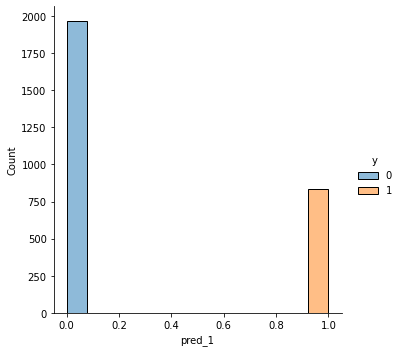

In [41]:
ax=sns.displot(data=pr_df, 
               x='pred_1', 
               hue='y')

Accuracy = 93.14% F1 Score= 88.0% 
Precision=91.79% Recall= 84.51%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.92      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



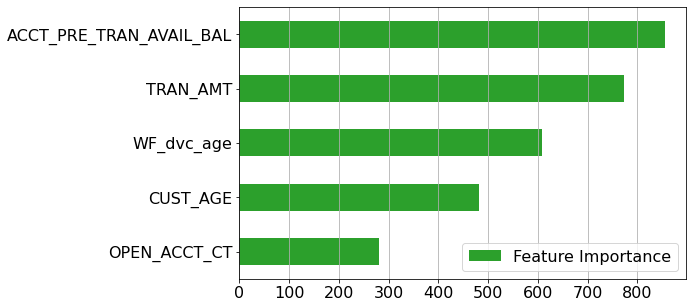

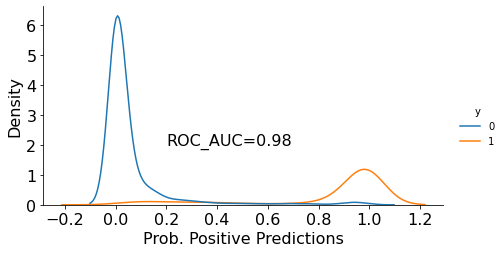

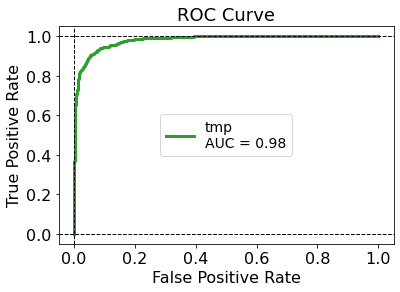

In [31]:
lgbm = LGBMClassifier()
mod = Model_training(lgbm,
                     X_train2, y_train2, X_test2, y_test2,
                     "tmp")

mod_tr, _= mod.print_metrics()
mod.feature_importance()
mod.displot()
mod.plot_roc_curve()

Accuracy = 100.0% F1 Score= 100.0% 
Precision=100.0% Recall= 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1967
           1       1.00      1.00      1.00       833

    accuracy                           1.00      2800
   macro avg       1.00      1.00      1.00      2800
weighted avg       1.00      1.00      1.00      2800



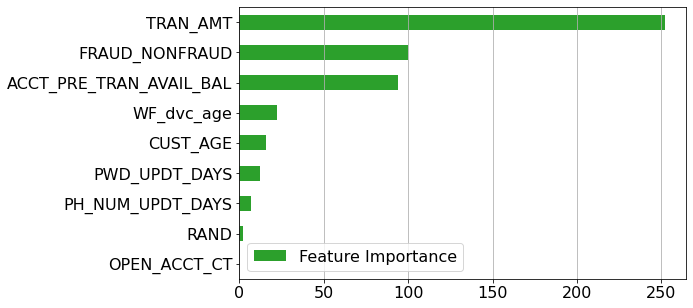

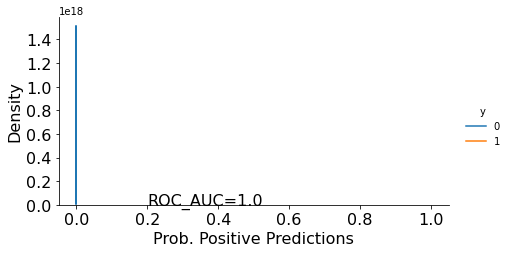

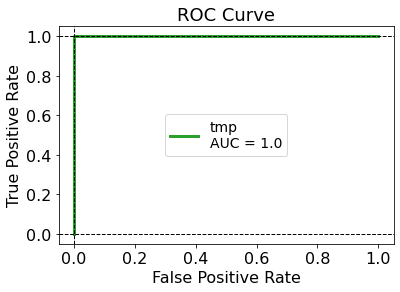

In [19]:
lgbm = LGBMClassifier()
mod = Model_training(lgbm,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")

mod_tr, _= mod.print_metrics()
mod.feature_importance()
mod.displot()
mod.plot_roc_curve()

In [26]:
# lightgbm for classification
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
X, y = make_classification(n_samples=1000, n_features=10,
                           n_informative=5, n_redundant=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print (accuracy_score(y_test, y_pred))
print (f1_score(y_test, y_pred))

0.9787878787878788
0.9794721407624633


In [23]:
#print('Prediction: %d' % yhat[0])
model.predict_proba(row)

array([[0.00200117, 0.99799883]])

In [ ]:
rf = RandomForestClassifier(max_depth=2)
mod = Model_training(rf,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")

mod_tr, _= mod.print_metrics()
mod.feature_importance()

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[2,3]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train1, y_train1, X_test1, y_test1,
                     "RF1")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1, "xgb1")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

## Modeling 2: Numerical features (Given + Engineered)

In [ ]:
X_train2, y_train2 = df1[nume_cols], df1["FRAUD_NONFRAUD"]
X_test2,  y_test2  = df1_te[nume_cols], df1_te["FRAUD_NONFRAUD"]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

In [ ]:
nume_cols.remove("RAND")

In [ ]:
X_train3, y_train3 = df1[nume_cols], df1["FRAUD_NONFRAUD"]
X_test3,  y_test3  = df1_te[nume_cols], df1_te["FRAUD_NONFRAUD"]
X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape

In [ ]:
nume_cols

In [ ]:
nume_cols2= ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL',
             'WF_dvc_age', 'PWD_UPDT_DAYS', 'PH_NUM_UPDT_DAYS']

In [ ]:
X_train4, y_train4 = df1[nume_cols2], df1["FRAUD_NONFRAUD"]
X_test4,  y_test4  = df1_te[nume_cols2], df1_te["FRAUD_NONFRAUD"]
X_train4.shape, y_train4.shape, X_test4.shape, y_test4.shape

In [ ]:
X_train3.head(2)

In [ ]:
X_test3.head(2)

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train4, y_train4, X_test4, y_test4,
                     "RF_6")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
mod.model.best_score_

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train3, y_train3, X_test3, y_test3,
                     "RF_5")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "RF_4")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "RF_2")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train2, y_train2, X_test2, y_test2, "xgb2")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [ ]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train2, y_train2, X_test2, y_test2, "xgb2")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

## Modeling 3: Numerical + Categorical features

In [24]:
import category_encoders as ce

In [25]:
df1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD,TRAN_HOUR,PH_NUM_UPDT_DT,PWD_UPDT_DT,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,RAND
2413,487.93,3714.91,43,5,1037,5/18/2020 4:7:20,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-13,1,05,2020-05-01,1988-01-11,12146,347,0.850464
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-29,0,22,1987-04-05,2017-04-12,1478,12443,0.990021


In [27]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = feature_engineering(df2)
nume_cols, cate_cols, impute_vals = get_imputation_values(df2)
df2 = impute_data(df2, impute_vals)
df2 = transform_cate_data(df2)

In [28]:
nume_cols, cate_cols

(['TRAN_AMT',
  'ACCT_PRE_TRAN_AVAIL_BAL',
  'CUST_AGE',
  'OPEN_ACCT_CT',
  'WF_dvc_age',
  'PWD_UPDT_DAYS',
  'PH_NUM_UPDT_DAYS',
  'RAND'],
 ['PWD_UPDT_TS',
  'CARR_NAME',
  'RGN_NAME',
  'STATE_PRVNC_TXT',
  'ALERT_TRGR_CD',
  'DVC_TYPE_TXT',
  'AUTHC_PRIM_TYPE_CD',
  'AUTHC_SCNDRY_STAT_TXT',
  'CUST_STATE',
  'PH_NUM_UPDT_TS',
  'CUST_SINCE_DT',
  'TRAN_TS',
  'TRAN_DT',
  'ACTN_CD',
  'ACTN_INTNL_TXT',
  'TRAN_TYPE_CD',
  'ACTVY_DT',
  'TRAN_HOUR',
  'PH_NUM_UPDT_DT',
  'PWD_UPDT_DT',
  'CUST_ZIP'])

In [32]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE"]

In [33]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df2[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join
y_train2 = df2["FRAUD_NONFRAUD"]

In [34]:
# test data
df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] = df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = feature_engineering(df2_te)
df2_te = impute_data(df2_te, impute_vals)
df2_te = transform_cate_data(df2_te)

In [35]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join
y_test2 = df2_te["FRAUD_NONFRAUD"]

In [36]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 15), (11200,), (2800, 15), (2800,))

Accuracy = 93.89% F1 Score= 89.42% 
Precision=92.22% Recall= 86.79%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.92      0.87      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.92      0.93      2800
weighted avg       0.94      0.94      0.94      2800



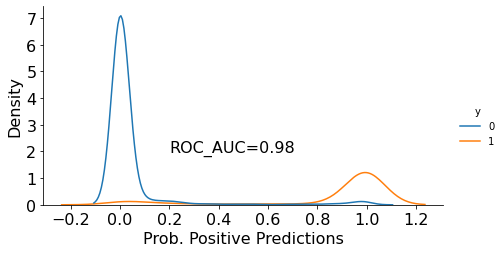

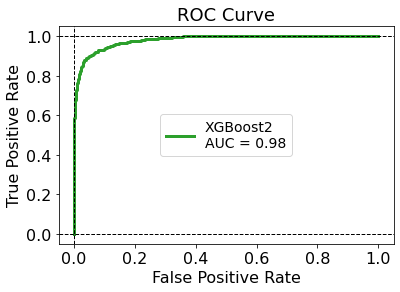

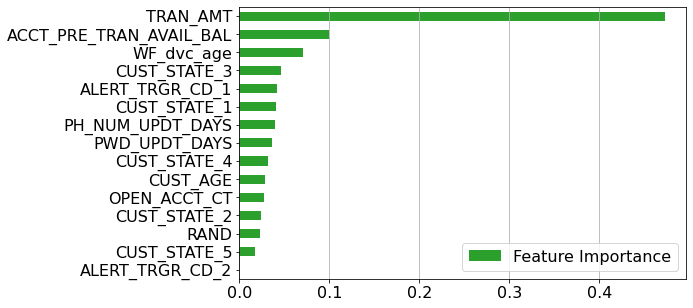

In [38]:
xgb = XGBClassifier(verbosity=1,
                    max_depth=10,
                    eval_metric = "logloss")

mod = Model_training(xgb, X_train2, y_train2, X_test2, y_test2, "XGBoost2")
mod_trained, _ = mod.print_metrics()
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   26.9s finished


Accuracy = 93.79% F1 Score= 89.15% 
Precision=92.74% Recall= 85.83%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



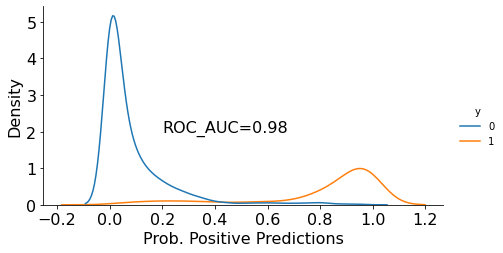

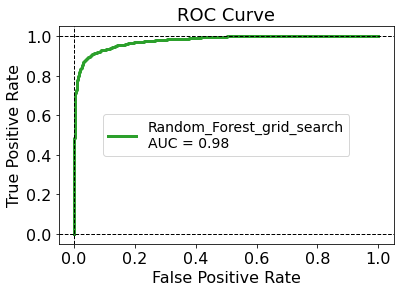

In [39]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[10, 11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train2, y_train2, X_test2, y_test2,
                     "Random_Forest_grid_search")

mod_tr, _= mod.print_metrics()
mod.displot()
mod.plot_roc_curve()

In [40]:
mod_tr.best_params_

{'max_depth': 15}

## Catboost

In [ ]:
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)

0:	learn: 0.4164857	total: 18.9ms	remaining: 170ms
1:	learn: 0.3199217	total: 35.4ms	remaining: 142ms
2:	learn: 0.2521437	total: 52.1ms	remaining: 122ms
3:	learn: 0.2123610	total: 92.6ms	remaining: 139ms
4:	learn: 0.1898842	total: 117ms	remaining: 117ms
5:	learn: 0.1746673	total: 130ms	remaining: 86.4ms
6:	learn: 0.1610488	total: 142ms	remaining: 60.7ms
7:	learn: 0.1529202	total: 152ms	remaining: 38ms
8:	learn: 0.1474430	total: 161ms	remaining: 17.9ms
9:	learn: 0.1431855	total: 170ms	remaining: 0us
0:	learn: 0.4323603	total: 12.2ms	remaining: 109ms
1:	learn: 0.3243941	total: 21.7ms	remaining: 86.7ms
2:	learn: 0.2572592	total: 34.3ms	remaining: 80ms
3:	learn: 0.2224352	total: 50.1ms	remaining: 75.2ms
4:	learn: 0.1975452	total: 70.5ms	remaining: 70.5ms
5:	learn: 0.1779430	total: 85.3ms	remaining: 56.9ms
6:	learn: 0.1683091	total: 100ms	remaining: 42.8ms
7:	learn: 0.1612555	total: 109ms	remaining: 27.3ms
8:	learn: 0.1526544	total: 118ms	remaining: 13.1ms
9:	learn: 0.1445806	total: 127ms	r

5:	learn: 0.1383638	total: 611ms	remaining: 407ms
6:	learn: 0.1269526	total: 758ms	remaining: 325ms
7:	learn: 0.1206842	total: 859ms	remaining: 215ms
8:	learn: 0.1132177	total: 948ms	remaining: 105ms
9:	learn: 0.1071068	total: 1.01s	remaining: 0us
0:	learn: 0.2791495	total: 85.4ms	remaining: 768ms
1:	learn: 0.2185168	total: 152ms	remaining: 610ms
2:	learn: 0.1777121	total: 214ms	remaining: 499ms
3:	learn: 0.1571994	total: 274ms	remaining: 411ms
4:	learn: 0.1389577	total: 349ms	remaining: 349ms
5:	learn: 0.1295538	total: 407ms	remaining: 271ms
6:	learn: 0.1218362	total: 482ms	remaining: 207ms
7:	learn: 0.1154794	total: 558ms	remaining: 140ms
8:	learn: 0.1101080	total: 641ms	remaining: 71.3ms
9:	learn: 0.1034311	total: 757ms	remaining: 0us
0:	learn: 0.2834044	total: 125ms	remaining: 1.13s
1:	learn: 0.2151538	total: 198ms	remaining: 790ms
2:	learn: 0.1832545	total: 265ms	remaining: 619ms
3:	learn: 0.1626708	total: 327ms	remaining: 491ms
4:	learn: 0.1447968	total: 395ms	remaining: 395ms
5:

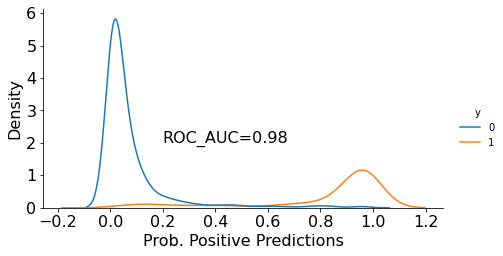

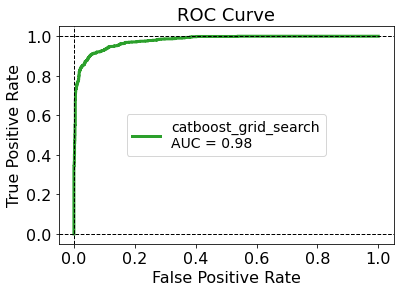

In [46]:
model_cb_gs = GridSearchCV(CatBoostClassifier(iterations=10),
                           param_grid={'depth':[10, 12, 16], 
                                       'learning_rate':[0.5, 1.],
                                       'loss_function':['Logloss']
                                      },
                           scoring ='f1',
                           verbose=0)

mod = Model_training(model_cb_gs,
                     X_train2, y_train2, X_test2, y_test2,
                     "catboost_grid_search")

mod_tr, _= mod.print_metrics()
mod.displot()
mod.plot_roc_curve()

In [42]:
#!pip3 install catboost

remove ALERT_TRGR_CD from features

In [ ]:
X_train2.head(1)

In [ ]:
cols = [c for c in list(X_train2.columns) if c not in ["ALERT_TRGR_CD_1","ALERT_TRGR_CD_2"]]
cols

In [ ]:
X_train3 = X_train2[cols]
X_test3  = X_test2[cols]
y_train3 = y_train2
y_test3  = y_test2

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod8 = Model_training(model_rf_gs,
                      X_train3, y_train3, X_test3, y_test3,
                      "Random_Forest_grid_search")

mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(gamma='auto')
mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [ ]:
def train_svm_gs():
    svm_gs = GridSearchCV(SVC(),
                          param_grid={'C':[0.1, 0.5, 1.0],
                                      'kernel':['poly', 'rbf'],
                                      'gamma': ['scale', 'auto']},
                          scoring = 'f1',
                          verbose = 1 )
    
    mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
    mod_tr, _= mod.print_metrics()
    mod.displot()
    
#this takes a little long time so think before running
#train_svm_gs()

## Voting Classifier

In [ ]:
#clf1 = LogisticRegression(multi_class='multinomial', random_state=1)

clf2 = RandomForestClassifier(max_depth=10,
                              random_state=8848)

clf3 = XGBClassifier(verbosity=1,
                    max_depth=13,
                    eval_metric = "logloss")

clf_voting = VotingClassifier(
    estimators=[('rf', clf2), ('xgb', clf3)],
    voting='soft')

In [ ]:
mod8 = Model_training(clf_voting, X_train1, y_train1, X_test1, y_test1, "Voting Classifier")
mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()
#mod8.feature_importance()